# Vacancy detection using Gaussian kernel

Motivation: At the end of the hands-on session, we saw a promising figure showing a clear location of the vacancy. The idea was very simple: via Gaussian [kernel](https://en.wikipedia.org/wiki/Kernel_regression), define the local density $\rho(r)$ via:

\begin{align}
\rho(r) = \sum_i \frac{w}{\left(\sqrt{2\pi\sigma^2}\right)^3}\exp\left(-\frac{(r-r_i)^2}{2\sigma^2}\right)
\end{align}
where the summation is meant to go over all atom positions.

<img src="IMAGE/gauss_example.png" style="width: 400px;"/>

However, we had the following drawbacks:

- Slow
- Not clear how to identify vacancies numerically
- Not clear how to locate the vacancy positions

In [1]:
from pyiron import Project
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
pr = Project('VACANCY')

In [3]:
def get_structure(number_of_vacancy=1, lattice_constant=4.024, element='Al', n_repeat=5, seed=0):
    structure = Project('.').create_structure('Al', 'fcc', lattice_constant).repeat(n_repeat)
    structure.lattice_constant = lattice_constant
    if seed is not None:
        np.random.seed(seed)
    vacancy_id = np.random.choice(np.arange(len(structure)), size=number_of_vacancy, replace=False)
    structure.vacancy_positions = structure.positions[vacancy_id]
    del structure[vacancy_id]
    return structure

In [4]:
def create_structure(positions, element, pr=pr):
    x = np.asarray(positions).reshape(-1, 3)
    return pr.create_atoms(positions=x, elements=len(x)*[element])

# Class setup

In [34]:
class Gaussian:
    def __init__(self, structure, sigma, cutoff, w):
        self.neigh = structure.get_neighborhood(np.random.random(3), cutoff_radius=cutoff, num_neighbors=None)
        self.sigma = sigma
        self.prefactor = w/np.sqrt(2*np.pi*sigma**2)**3

    def update(self, positions):
        self.neigh = self.neigh.get_neighborhood(positions)
        self.neigh.vecs[self.neigh.distances==np.inf] *= 0

    def get_value(self):
        return self.prefactor*np.einsum('nm->n', np.exp(-self.neigh.distances**2/(2*sigma**2)))
    
    def get_gradient(self):
        w = -self.prefactor/self.sigma**2
        return w*np.einsum('nmi,nm->ni', -self.neigh.vecs, np.exp(-self.neigh.distances**2/(2*self.sigma**2)))

    def get_hessian(self):
        kappa = np.exp(-self.neigh.distances**2/(2*self.sigma**2))
        first_term = -self.prefactor/self.sigma**2*np.einsum('ab,nm->nab', np.eye(3), kappa)
        second_term = self.prefactor/self.sigma**4*np.einsum(
            'nma,nmb,nm->nab', self.neigh.vecs, self.neigh.vecs, kappa
        )
        return first_term+second_term

# 0K

## One Vacancy

### First try

We choose relatively random parameters first to see what kind of results we are going to get

In [35]:
structure = get_structure(number_of_vacancy=1)

In [36]:
sigma = structure.lattice_constant
cutoff = 3*sigma
w = 100

In [37]:
gauss = Gaussian(structure, sigma, cutoff, w)

current_positions = structure.positions.copy()

print('Minimum distance between vacancy/vacancies and initial points:',
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

Minimum distance between vacancy/vacancies and initial points: [2.84539769]


In [38]:
%%time
n_steps = 100
for _ in range(n_steps):
    gauss.update(current_positions)
#     print(gauss.get_value())
    gradient = gauss.get_gradient()
    current_positions = structure.get_wrapped_coordinates(current_positions-gradient)

CPU times: user 10 s, sys: 29.8 ms, total: 10.1 s
Wall time: 10.1 s


In [39]:
print('Minimum distance between vacancy/vacancies and points after {} steps:'.format(n_steps),
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

Minimum distance between vacancy/vacancies and points after 100 steps: [1.68098325]


In [40]:
(structure+create_structure(current_positions, 'Ni')).plot3d()

NGLWidget()

At this point, we can see that the minimum distance became somewhat smaller, and we can also see some points moving towards something, but we can also see that it takes a tremendous amount of time to compute the displacements.

On the other hand, the plot shows that most of the points actually do not move, which is not surprising, but it's extremely inefficient that we're calculating displacements for these points as well -> Why not consider only points with a relatively large Voronoi volume and use only them as the initial points?

### Use Voronoi volume

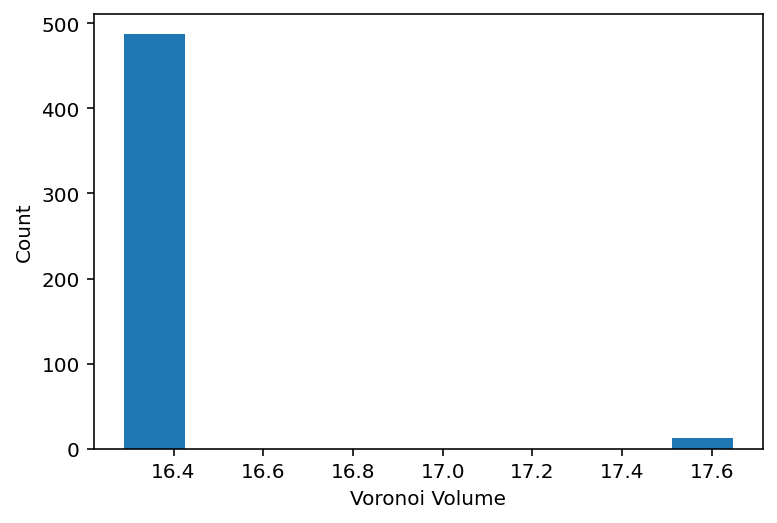

In [41]:
plt.xlabel('Voronoi Volume')
plt.ylabel('Count')
plt.hist(structure.analyse_ovito_voronoi_volume());

In [42]:
min_voronoi_volume = 17
current_positions = structure.positions[structure.analyse_ovito_voronoi_volume()>min_voronoi_volume]

In [43]:
%%time
n_steps = 1000
for _ in range(n_steps):
    gauss.update(current_positions)
#     print(gauss.get_value())
    gradient = gauss.get_gradient()
    current_positions = structure.get_wrapped_coordinates(current_positions-gradient)

CPU times: user 4.88 s, sys: 77.5 ms, total: 4.96 s
Wall time: 5.02 s


In [44]:
(structure+create_structure(structure.vacancy_positions, 'O')+create_structure(current_positions, 'Ni')).plot3d()

NGLWidget()

Compared to the previous case, the computation time is now acceptable. On the other hand, we can see that the prediction does not get better with the increasing number of steps. This can be understood with the following graph:

In [48]:
neigh = structure.get_neighborhood(structure.vacancy_positions.flatten(), num_neighbors=None, cutoff_radius=2*cutoff)

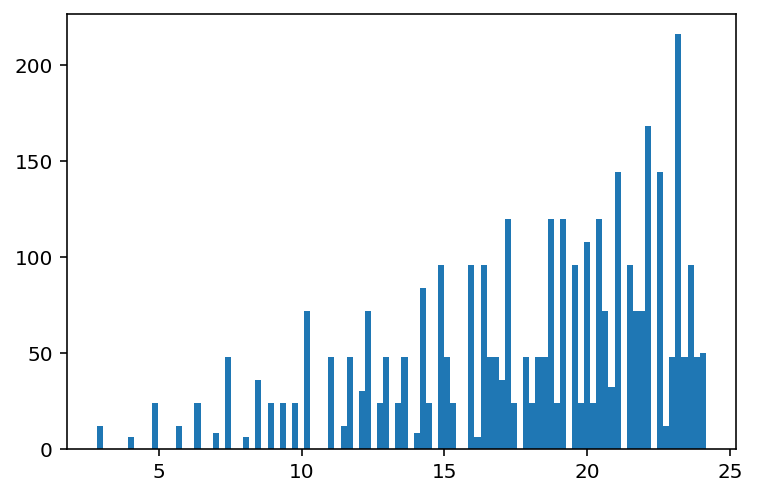

In [50]:
hist = plt.hist(neigh.distances, bins=100)

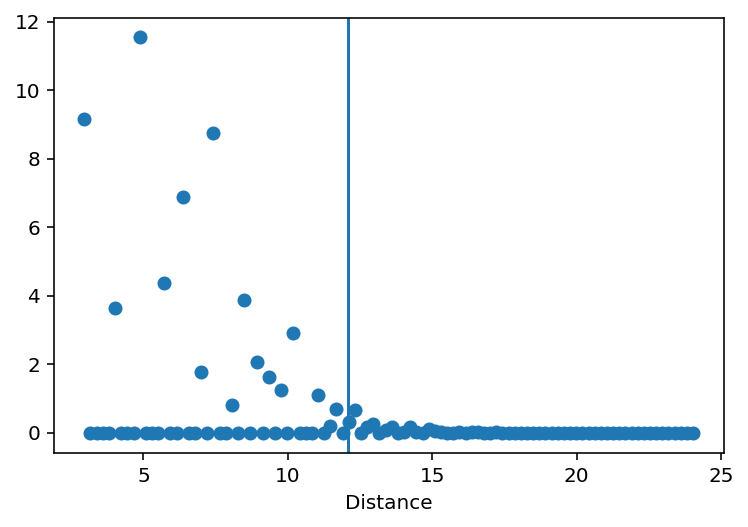

In [51]:
# x_range = np.linspace(0, 1.1*cutoff)
# plt.plot(x_range, np.exp(-x_range**2/(2*sigma**2)), '--')
# plt.plot(hist[1], np.exp(-hist[1]**2/(2*sigma**2)));
x = 0.5*(hist[1][1:]+hist[1][:-1])
plt.axvline(cutoff)
plt.xlabel('Distance')
plt.plot(x, hist[0]*np.exp(-x**2/(2*sigma**2)), 'o');

The graph above shows the histogram of distances and the contribution to the Gaussian kernel for each point together with the cutoff length. We can se that there are still a few points beyond the cutoff length which still have to be taken into account -> increase cutoff

### Increased cutoff

In [ ]:
cutoff = 4*sigma

In [ ]:
gauss = Gaussian(structure, sigma, cutoff, w)

min_voronoi_volume = 17
current_positions = structure.positions[structure.analyse_ovito_voronoi_volume()>min_voronoi_volume]

print('Minimum distance between vacancy/vacancies and initial points:',
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
%%time
n_steps = 1000
for _ in range(n_steps):
    gauss.update(current_positions)
#     print(gauss.get_value())
    gradient = gauss.get_gradient()
    current_positions = structure.get_wrapped_coordinates(current_positions-gradient)

In [ ]:
print('Minimum distance between vacancy/vacancies and points after {} steps:'.format(n_steps),
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
(structure+create_structure(structure.vacancy_positions, 'O')+create_structure(current_positions, 'Ni')).plot3d()

This time it looks like it converged. Let's take a look at the average position and compare it with the real positions

In [ ]:
print('Predicted vacancy position:', np.mean(current_positions, axis=0))

In [ ]:
print('Original vacancy position:', structure.vacancy_positions)

## Multiple vacancies

### First try

In [ ]:
structure = get_structure(number_of_vacancy=3)

In [ ]:
gauss = Gaussian(structure, sigma, cutoff, w)

min_voronoi_volume = 17
current_positions = structure.positions[structure.analyse_ovito_voronoi_volume()>min_voronoi_volume]

print('Minimum distance between vacancy/vacancies and initial points:',
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
%%time
n_steps = 1000
for _ in range(n_steps):
    gauss.update(current_positions)
#     print(gauss.get_value())
    gradient = gauss.get_gradient()
    current_positions = structure.get_wrapped_coordinates(current_positions-gradient)

In [ ]:
print('Minimum distance between vacancy/vacancies and points after {} steps:'.format(n_steps),
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
(structure+create_structure(structure.vacancy_positions, 'O')+create_structure(current_positions, 'Ni')).plot3d()

This time we can see that the distances were not enormously reduced. A look at the final snapshot makes the reason clear: the vacancies obviously see each other and the points could not exactly converge to where they should. This is caused by the fact that the Gaussian kernel had a high width, as the diagram below shows:

In [ ]:
x_range = np.linspace(-1, 1, 1000)*cutoff
plt.xlabel('Distance A')
plt.ylabel('Density')
plt.plot(x_range, np.exp(-x_range**2/(2*sigma**2)));

### Reduce sigma

In [ ]:
sigma = structure.lattice_constant/2

In [ ]:
gauss = Gaussian(structure, sigma, cutoff, w)

min_voronoi_volume = 17
current_positions = structure.positions[structure.analyse_ovito_voronoi_volume()>min_voronoi_volume]

print('Minimum distance between vacancy/vacancies and initial points:',
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
%%time
n_steps = 1000
for _ in range(n_steps):
    gauss.update(current_positions)
#     print(gauss.get_value())
    gradient = gauss.get_gradient()
    current_positions = structure.get_wrapped_coordinates(current_positions-gradient)

In [ ]:
print('Minimum distance between vacancy/vacancies and points after {} steps:'.format(n_steps),
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
(structure+create_structure(structure.vacancy_positions, 'O')+create_structure(current_positions, 'Ni')).plot3d()

Now since the points obviously converged, let's take a look at the average positions. For this, we can use an agglomerative method:

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1*sigma, linkage='complete').fit(current_positions)

In [ ]:
for label in np.unique(cluster.labels_):
    print(np.mean(current_positions[cluster.labels_==label], axis=0))

In [ ]:
structure.vacancy_positions

# Finite temperature

In [ ]:
job = pr.create_job('Lammps', 'lmp', True)
job.structure = get_structure(number_of_vacancy=3)
job.calc_md(temperature=500)
job.run()

In [ ]:
structure = job.get_structure()

In [ ]:
plt.xlabel('Voronoi volume')
plt.hist(structure.analyse_ovito_voronoi_volume(), bins=100);

In [ ]:
gauss = Gaussian(structure, sigma, cutoff, w)

min_voronoi_volume = 17
current_positions = structure.positions[structure.analyse_ovito_voronoi_volume()>min_voronoi_volume]

print('Minimum distance between vacancy/vacancies and initial points:',
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
%%time
n_steps = 1000
for _ in range(n_steps):
    gauss.update(current_positions)
#     print(gauss.get_value())
    gradient = gauss.get_gradient()
    current_positions = structure.get_wrapped_coordinates(current_positions-gradient)

In [ ]:
print('Minimum distance between vacancy/vacancies and points after {} steps:'.format(n_steps),
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
(structure+create_structure(current_positions, 'Ni')).plot3d()

This time, there are a few candidates for vacancies. In our case we know that there are 3 vacancies, but in general this information is not at disposal.

Consideration: From the volume per atom $v$, why not calculate the minimum radius $r_0$ via:

\begin{align}
v =& \frac{4}{3}\pi r_0^3\\
\Longrightarrow r_0 =& \left(\frac{3v}{4\pi}\right)^{1/3}
\end{align}

In [ ]:
cluster = AgglomerativeClustering(distance_threshold=0.1*sigma, linkage='complete', n_clusters=None).fit(current_positions)

In [ ]:
v_lst = []
for label in np.unique(cluster.labels_):
    v_lst.append(np.mean(current_positions[label==cluster.labels_], axis=0))
v_lst = np.array(v_lst)

In [ ]:
v_lst

In [ ]:
r0 = (4*structure.get_volume(per_atom=True)/(3*np.pi))**(1/3)

In [ ]:
distances = gauss.tree.query(v_lst)[0]

In [ ]:
plt.axhline(r0)
plt.plot(distances, 'o');

In [ ]:
structure.get_distances_array(structure.vacancy_positions, v_lst[distances>r0])

## Conjugate gradient?

In [ ]:
structure = job.get_structure()

In [ ]:
plt.xlabel('Voronoi volume')
plt.hist(structure.analyse_ovito_voronoi_volume(), bins=100);

In [ ]:
gauss = Gaussian(structure, sigma, cutoff, w)

min_voronoi_volume = 17
current_positions = structure.positions[structure.analyse_ovito_voronoi_volume()>min_voronoi_volume]

print('Minimum distance between vacancy/vacancies and initial points:',
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

In [ ]:
# %%time
for _ in range(10):
    gauss.update(current_positions)
    gradient = gauss.get_gradient()
    current_positions = structure.get_wrapped_coordinates(current_positions-gradient)    


In [ ]:
# %%time
for _ in range(10):
    gauss.update(current_positions)
    displacement = -np.einsum('nij,nj->ni', gauss.get_hessian(), gauss.get_gradient())
    current_positions = structure.get_wrapped_coordinates(current_positions+displacement)

In [ ]:
np.linalg.norm(gauss.get_gradient(), axis=-1)

In [ ]:
print('Minimum distance between vacancy/vacancies and points after {} steps:'.format(n_steps),
      structure.get_distances_array(structure.vacancy_positions, current_positions).min(axis=-1))

# Conclusion

- Use atom positions for the starting point (instead of making fine mesh)
- Select best points using Voronoi analysis
- Choose at least $4\sigma$ for the cutoff
- Determine a good value for $\sigma$
- Use agglomerative method to cluster points
- Determine whether a point is a vacancy or not using minimum radius